# Computational Time Analysis on the AI-ready PHIPS Image Classification Dataset

##### This notebook performs a thorough analysis of the computational time needed for training and deployment of the top 5 best-performing models for classifying features in the "PHIPS_CrystalHabitAI_Dataset.nc" dataset, as determined in the `autoML_hyperparamter_tuning.iypnb` notebook. This models include: Random Forest, Extra Trees, Gradient Boosting Classifier, Light Gradient Boosting Machine (LightGBM), and Logistic Regression.

## Data pre-processing 

In [2]:
# Import basic packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Define the file path of the dataset
file_path = '/home/disk/meso-home/vgarcia1/PHIPS_classification/PHIPS_CrystalHabitAI_Dataset.nc'

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)

In [4]:
# Flatten the image arrays (convert each image from a 2D array to a 1D vector)
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Scales features in data using statistics that are robust to outliers.
# Before applying PCA (a dimensionality reduction method), it's important to scale the data so that each feature contributes equally to the analysis.

from sklearn.preprocessing import RobustScaler

# Apply Robust Scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(image_arrays)

from sklearn.decomposition import PCA

# Apply PCA with the optimal number of components (63 in this case, obtained from the 'autoML_hyperparameter_tuning.ipynb' notebook)
pca = PCA(n_components=63)
pca_result = pca.fit_transform(scaled_data)

# Convert the PCA results into a DataFrame
pca_columns = [f'PC{i+1}' for i in range(63)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
pca_df['habit_type'] = ds['label'].values  # Adding the target label

In [5]:
from sklearn.model_selection import train_test_split

# Split the data
X = pca_df.drop(columns='habit_type')  # Features
y = pca_df['habit_type']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform y_train
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform y_test using the same encoder
y_test_encoded = label_encoder.transform(y_test)

## 1. Training Time Metrics
##### **Task:** Measure the training time for each model and evaluate how specific parameters (like the number of estimators or maximum depth) impact speed. 
##### The code below provides the training time and accuracy for each model configuration, giving insights into how different parameter settings impact speed and performance.

In [6]:
import time
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# List to store results
results = []

# Model configurations with various parameters for comparison
model_configs = [
    ("Random Forest (10 Trees, max_depth=5)", RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)),
    ("Random Forest (50 Trees, max_depth=10)", RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)),
    ("Extra Trees (10 Trees, max_depth=5)", ExtraTreesClassifier(n_estimators=10, max_depth=5, random_state=42)),
    ("Extra Trees (50 Trees, max_depth=10)", ExtraTreesClassifier(n_estimators=50, max_depth=10, random_state=42)),
    ("Gradient Boosting (50 Estimators, max_depth=3)", GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)),
    ("LightGBM (50 Trees, max_depth=7)", LGBMClassifier(n_estimators=50, max_depth=7, random_state=42, verbose=-1)),
    ("Logistic Regression (max_iter=100)", LogisticRegression(max_iter=100, solver='saga', random_state=42)),
    ("Logistic Regression (max_iter=500)", LogisticRegression(max_iter=500, solver='saga', random_state=42))
]

# Measure training time for each configuration
for name, model in model_configs:
    start_time = time.time()
    model.fit(X_train, y_train_encoded)  # Train model
    end_time = time.time()
    
    # Calculate training time and accuracy
    train_time = end_time - start_time
    accuracy = accuracy_score(y_test_encoded, model.predict(X_test))
    
    # Store results
    results.append((name, train_time, accuracy))
    print(f"{name} - Training Time: {train_time:.4f} seconds - Accuracy: {accuracy:.4f}")

/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Random Forest (10 Trees, max_depth=5) - Training Time: 0.0317 seconds - Accuracy: 0.2841
Random Forest (50 Trees, max_depth=10) - Training Time: 0.1092 seconds - Accuracy: 0.3295
Extra Trees (10 Trees, max_depth=5) - Training Time: 0.0089 seconds - Accuracy: 0.2386
Extra Trees (50 Trees, max_depth=10) - Training Time: 0.0459 seconds - Accuracy: 0.3977
Gradient Boosting (50 Estimators, max_depth=3) - Training Time: 3.6428 seconds - Accuracy: 0.4318
LightGBM (50 Trees, max_depth=7) - Training Time: 0.3357 seconds - Accuracy: 0.4091
Logistic Regression (max_iter=100) - Training Time: 0.1286 seconds - Accuracy: 0.3409


/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression (max_iter=500) - Training Time: 0.5938 seconds - Accuracy: 0.3750


/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 2. Time vs. Accuracy Trade-offs for Different Configurations
##### **Task:** Analyze the trade-off between training time and accuracy by plotting these metrics for each configuration. This will help to identify the most efficient configurations in terms of computational cost and predictive power.

##### The scatter plot below displays the training time vs. accuracy trade-offs for each model configuration. This helps in identifying which configurations yield a good balance between accuracy and computational cost.


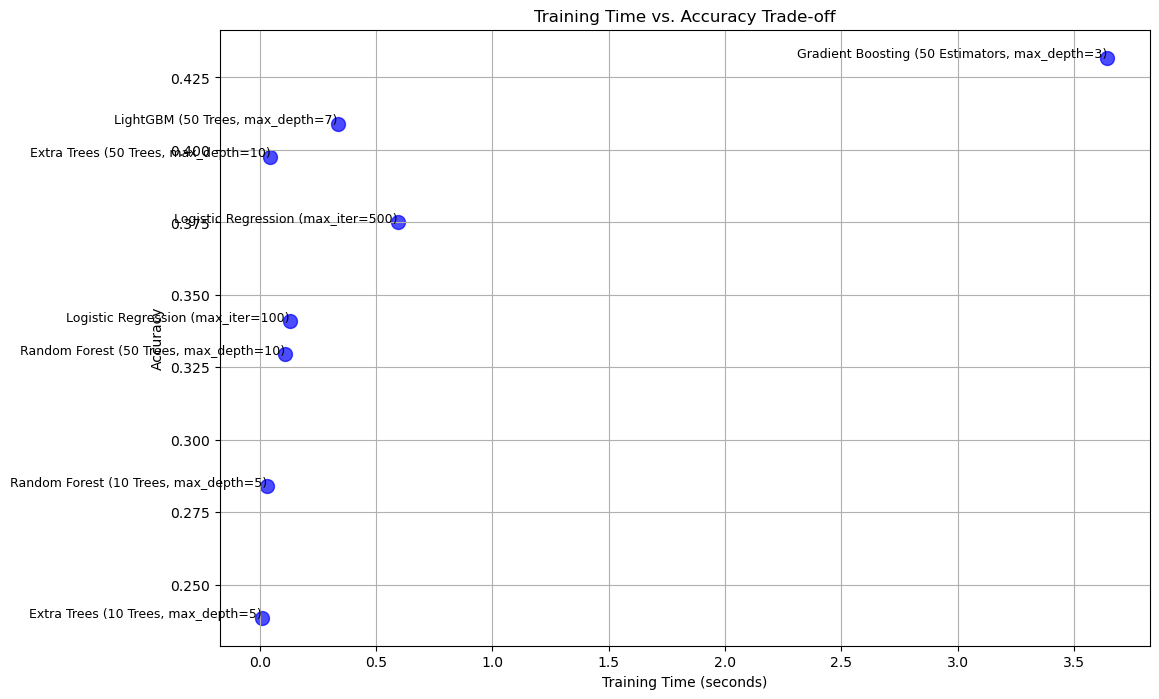

In [7]:
# Plotting Time vs. Accuracy Trade-offs

# Extract data for plotting
model_names = [result[0] for result in results]
train_times = [result[1] for result in results]
accuracies = [result[2] for result in results]

# Plot time vs. accuracy
plt.figure(figsize=(12, 8))
plt.scatter(train_times, accuracies, color="blue", s=100, alpha=0.7)
for i, txt in enumerate(model_names):
    plt.annotate(txt, (train_times[i], accuracies[i]), fontsize=9, ha="right")
plt.xlabel("Training Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Training Time vs. Accuracy Trade-off")
plt.grid()
plt.show()

## 3. Deployment Time Requirements
##### In real-world scenarios, inference time (time to predict for a single sample) is critical for applications requiring quick predictions. 
##### **Task:** Calculate the average inference time per sample to estimate the model’s deployment feasibility.
##### The code below provides the inference time per sample for each model configuration, offering insight into their feasibility for real-time applications.

In [8]:
# Measure inference time for each model on a single sample
sample = X_test.iloc[0:1, :]  # Use a single sample for timing

for name, model in model_configs:
    model.fit(X_train, y_train_encoded)  # Ensure the model is trained
    
    # Measure inference time
    start_time = time.time()
    model.predict(sample)  # Make a prediction on one sample
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"{name} - Inference Time per Sample: {inference_time:.6f} seconds")

Random Forest (10 Trees, max_depth=5) - Inference Time per Sample: 0.002054 seconds
Random Forest (50 Trees, max_depth=10) - Inference Time per Sample: 0.002802 seconds
Extra Trees (10 Trees, max_depth=5) - Inference Time per Sample: 0.001401 seconds
Extra Trees (50 Trees, max_depth=10) - Inference Time per Sample: 0.002820 seconds
Gradient Boosting (50 Estimators, max_depth=3) - Inference Time per Sample: 0.001858 seconds


/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LightGBM (50 Trees, max_depth=7) - Inference Time per Sample: 0.014086 seconds
Logistic Regression (max_iter=100) - Inference Time per Sample: 0.001617 seconds
Logistic Regression (max_iter=500) - Inference Time per Sample: 0.001108 seconds


/home/disk/meso-home/vgarcia1/anaconda3/envs/impacts/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Summary
##### INSERT FINDINGS BASED ON RESULTS ABOVE, FOCUSING ON ANY COMPUTATIONAL CHALLENGES OR OPTIMIZATIONS RELEVANT TO THE MODEL(S)